<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import warnings
import gc
from sklearn.linear_model import Ridge

In [68]:
merchants = pd.read_csv('data/elo/merchants.csv')

In [69]:
merchants.head().T

,0,1,2,3,4
merchant_id,M_ID_838061e48c,M_ID_9339d880ad,M_ID_e726bbae1e,M_ID_a70e9c5f81,M_ID_64456c37ce
merchant_group_id,8353,3184,447,5026,2228
merchant_category_id,792,840,690,792,222
subsector_id,9,20,1,9,21
numerical_1,-0.0574706,-0.0574706,-0.0574706,-0.0574706,-0.0574706
numerical_2,-0.0574706,-0.0574706,-0.0574706,-0.0574706,-0.0574706
category_1,N,N,N,Y,Y
most_recent_sales_range,E,E,E,E,E
most_recent_purchases_range,E,E,E,E,E
avg_sales_lag3,-0.4,-0.72,-82.13,NaN,NaN


In [70]:
merchant_details_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id', 'subsector_id', 'category_1', 
                        'category_4', 'city_id', 'state_id', 'category_2']

merchant_details = merchants[merchant_details_cols]

# Delete duplicates
merchant_details = merchant_details.drop_duplicates()

u = merchant_details['merchant_id'].value_counts()
print("Number of merchant_id with more than 1 observation", len(u[u.values != 1]))
multi_obs_merchant_ids = u[u.values != 1].index
# get all rows with these merchant_ids from the table
multi_observ_table = merchant_details[merchant_details['merchant_id'].isin(multi_obs_merchant_ids)]
marchant_id_groups = multi_observ_table.groupby('merchant_id')

for n in list(marchant_id_groups.groups.keys()):
    a_merchant_id_group = marchant_id_groups.get_group(n)
    x = [col for col in a_merchant_id_group.columns if a_merchant_id_group[col].nunique()>1]
    print("ID =", n, '\tVariation in columns:', x)


Number of merchant_id with more than 1 observation 12
ID = M_ID_1802942aaf 	Variation in columns: ['merchant_group_id']
ID = M_ID_30340088f2 	Variation in columns: ['merchant_group_id']
ID = M_ID_42697d5d44 	Variation in columns: ['merchant_group_id']
ID = M_ID_645a6af169 	Variation in columns: ['merchant_group_id', 'merchant_category_id', 'city_id', 'state_id', 'category_2']
ID = M_ID_6464db3b45 	Variation in columns: ['merchant_group_id']
ID = M_ID_992a180b15 	Variation in columns: ['merchant_group_id']
ID = M_ID_bd49e37dda 	Variation in columns: ['merchant_group_id']
ID = M_ID_c2b9ac2ea4 	Variation in columns: ['merchant_group_id']
ID = M_ID_d123532c72 	Variation in columns: ['merchant_group_id']
ID = M_ID_dbbf07ebf0 	Variation in columns: ['merchant_group_id']
ID = M_ID_ebbdb42da6 	Variation in columns: ['merchant_group_id']
ID = M_ID_ef233cff26 	Variation in columns: ['merchant_group_id']


In [71]:
merchants['category_2'] = merchants['category_2'].fillna(0).astype(int)
merchants.loc[merchants['city_id'] == -1, 'city_id'] = 0
merchants.loc[merchants['state_id'] == -1, 'state_id'] = 0

In [72]:
merchant_address_id = merchants['merchant_id'].map(str)+ '_' + \
    merchants['merchant_category_id'].map(str) + '_'+ \
    merchants['subsector_id'].map(str) + '_'+ \
    merchants['city_id'].map(str) + '_'+ \
    merchants['state_id'].map(str) + '_'+ \
    merchants['category_2'].map(str)
    
merchants['merchant_address_id'] = merchant_address_id

In [73]:
# merchants.drop(['merchant_id', 'merchant_category_id', 'subsector_id', 
#                          'city_id', 'state_id', 'category_2'], axis=1, inplace=True)

merchants.head(10)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2,merchant_address_id
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,18.666667,6,-2.32,13.916667,12,N,242,9,1,M_ID_838061e48c_792_9_242_9_1
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,1.291667,6,-0.57,1.687500,12,N,22,16,1,M_ID_9339d880ad_840_20_22_16_1
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,260.000000,2,-82.13,260.000000,2,N,0,5,5,M_ID_e726bbae1e_690_1_0_5_5
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,4.666667,6,NaN,3.833333,12,Y,0,0,0,M_ID_a70e9c5f81_792_9_0_0_0
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,0.361111,6,NaN,0.347222,12,Y,0,0,0,M_ID_64456c37ce_222_21_0_0_0
5,M_ID_a0915f62b5,20201,87,27,-0.057471,-0.057471,N,E,E,NaN,...,3.666667,6,NaN,3.833333,12,Y,160,21,5,M_ID_a0915f62b5_87_27_160_21_5
6,M_ID_bfd41933db,33861,792,9,-0.057471,-0.057471,N,E,E,NaN,...,4.833333,6,NaN,6.333333,12,N,60,16,1,M_ID_bfd41933db_792_9_60_16_1
7,M_ID_d8ff08219e,16430,529,20,-0.057471,-0.057471,Y,E,E,NaN,...,1.666667,6,NaN,1.500000,11,Y,0,0,0,M_ID_d8ff08219e_529_20_0_0_0
8,M_ID_c5b389236d,37179,813,29,-0.057471,-0.057471,N,E,E,NaN,...,189.916667,6,NaN,197.000000,7,N,248,15,1,M_ID_c5b389236d_813_29_248_15_1
9,M_ID_d2162ed113,112122,81,29,-0.057471,-0.057471,Y,E,E,NaN,...,1.000000,2,NaN,1.000000,2,Y,0,0,0,M_ID_d2162ed113_81_29_0_0_0


In [74]:
def rating(x):
    if np.isfinite(x) or x < 0:
        x = (1/x) - 1
        
        if x>1:
            r = 1
        elif x <= 1 and x > 0:
            r = 2
        elif x == 0:
            r = 3
        elif x < 0 and x >= -1:
            r = 4
        else:
            r = 5
    else:
        r = 5
    return r

In [75]:
merchants['avg_sales_lag3'] = (merchants['avg_sales_lag3'] / merchants['active_months_lag3']) * 3
merchants['avg_purchases_lag3'] = (merchants['avg_purchases_lag3'] / merchants['active_months_lag3']) * 3
merchants['avg_sales_lag6'] = (merchants['avg_sales_lag6'] / merchants['active_months_lag6']) * 6
merchants['avg_purchases_lag6'] = (merchants['avg_purchases_lag6'] / merchants['active_months_lag6']) * 6
merchants['avg_sales_lag12'] = (merchants['avg_sales_lag12'] / merchants['active_months_lag12']) * 12
merchants['avg_purchases_lag12'] = (merchants['avg_purchases_lag12'] / merchants['active_months_lag12']) * 12


merchants['avg_sales_lag3'] = merchants['avg_sales_lag3'].map(rating)
merchants['avg_purchases_lag3'] = merchants['avg_purchases_lag3'].map(rating)

merchants['avg_sales_lag6'] = merchants['avg_sales_lag6'].map(rating)
merchants['avg_purchases_lag6'] = merchants['avg_purchases_lag6'].map(rating)

merchants['avg_sales_lag12'] = merchants['avg_sales_lag12'].map(rating)
merchants['avg_purchases_lag12'] = merchants['avg_purchases_lag12'].map(rating)

merchants = merchants.drop(['active_months_lag3', 'active_months_lag6', 'active_months_lag12'], axis=1)

merchants.head(10)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,avg_sales_lag6,avg_purchases_lag6,avg_sales_lag12,avg_purchases_lag12,category_4,city_id,state_id,category_2,merchant_address_id
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,242,9,1,M_ID_838061e48c_792_9_242_9_1
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,22,16,1,M_ID_9339d880ad_840_20_22_16_1
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,0,5,5,M_ID_e726bbae1e_690_1_0_5_5
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,5,4,5,4,5,4,Y,0,0,0,M_ID_a70e9c5f81_792_9_0_0_0
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,5,2,5,1,5,1,Y,0,0,0,M_ID_64456c37ce_222_21_0_0_0
5,M_ID_a0915f62b5,20201,87,27,-0.057471,-0.057471,N,E,E,5,3,5,4,5,4,Y,160,21,5,M_ID_a0915f62b5_87_27_160_21_5
6,M_ID_bfd41933db,33861,792,9,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,60,16,1,M_ID_bfd41933db_792_9_60_16_1
7,M_ID_d8ff08219e,16430,529,20,-0.057471,-0.057471,Y,E,E,5,3,5,4,5,4,Y,0,0,0,M_ID_d8ff08219e_529_20_0_0_0
8,M_ID_c5b389236d,37179,813,29,-0.057471,-0.057471,N,E,E,5,4,5,4,5,4,N,248,15,1,M_ID_c5b389236d_813_29_248_15_1
9,M_ID_d2162ed113,112122,81,29,-0.057471,-0.057471,Y,E,E,5,4,5,4,5,4,Y,0,0,0,M_ID_d2162ed113_81_29_0_0_0


In [76]:
merchants['sales_incrase_range'] = merchants[['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']].mean(axis=1)
merchants['purchase_incrase_range'] = merchants[['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']].mean(axis=1)

In [77]:
merchants['sales_incrase_range'] = merchants['sales_incrase_range'].round()
merchants['sales_incrase_range'] = merchants['sales_incrase_range'].astype(int)

merchants['purchase_incrase_range'] = merchants['purchase_incrase_range'].round()
merchants['purchase_incrase_range'] = merchants['purchase_incrase_range'].astype(int)

merchants = merchants.drop(['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12'], axis=1)
merchants = merchants.drop(['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12'], axis=1)

# Distribution of categories
print(pd.crosstab(merchants["sales_incrase_range"], merchants["most_recent_sales_range"],margins=True))

merchants.head(10)

most_recent_sales_range     A     B      C       D       E     All
sales_incrase_range                                               
1                           2    17    325    2752    3255    6351
2                         301  1569  12327   50037   47129  111363
3                         188  1159   8271   29922   42642   82182
4                         514  2292  13152   34764   84062  134784
5                           0     0      0       0      16      16
All                      1005  5037  34075  117475  177104  334696


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,category_4,city_id,state_id,category_2,merchant_address_id,sales_incrase_range,purchase_incrase_range
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,N,242,9,1,M_ID_838061e48c_792_9_242_9_1,5,4
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,N,22,16,1,M_ID_9339d880ad_840_20_22_16_1,5,4
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,N,0,5,5,M_ID_e726bbae1e_690_1_0_5_5,5,4
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,Y,0,0,0,M_ID_a70e9c5f81_792_9_0_0_0,5,4
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,Y,0,0,0,M_ID_64456c37ce_222_21_0_0_0,5,1
5,M_ID_a0915f62b5,20201,87,27,-0.057471,-0.057471,N,E,E,Y,160,21,5,M_ID_a0915f62b5_87_27_160_21_5,5,4
6,M_ID_bfd41933db,33861,792,9,-0.057471,-0.057471,N,E,E,N,60,16,1,M_ID_bfd41933db_792_9_60_16_1,5,4
7,M_ID_d8ff08219e,16430,529,20,-0.057471,-0.057471,Y,E,E,Y,0,0,0,M_ID_d8ff08219e_529_20_0_0_0,5,4
8,M_ID_c5b389236d,37179,813,29,-0.057471,-0.057471,N,E,E,N,248,15,1,M_ID_c5b389236d_813_29_248_15_1,5,4
9,M_ID_d2162ed113,112122,81,29,-0.057471,-0.057471,Y,E,E,Y,0,0,0,M_ID_d2162ed113_81_29_0_0_0,5,4


Data in histogram bins
 [334582     70     22      8      3      5      2      1      1      2]
Bins
 [ -0.05747  18.15621  36.36989  54.58357  72.79725  91.01093 109.22461 127.43828 145.65196 163.86564
 182.07932]
Mean: 0.008103109673703892


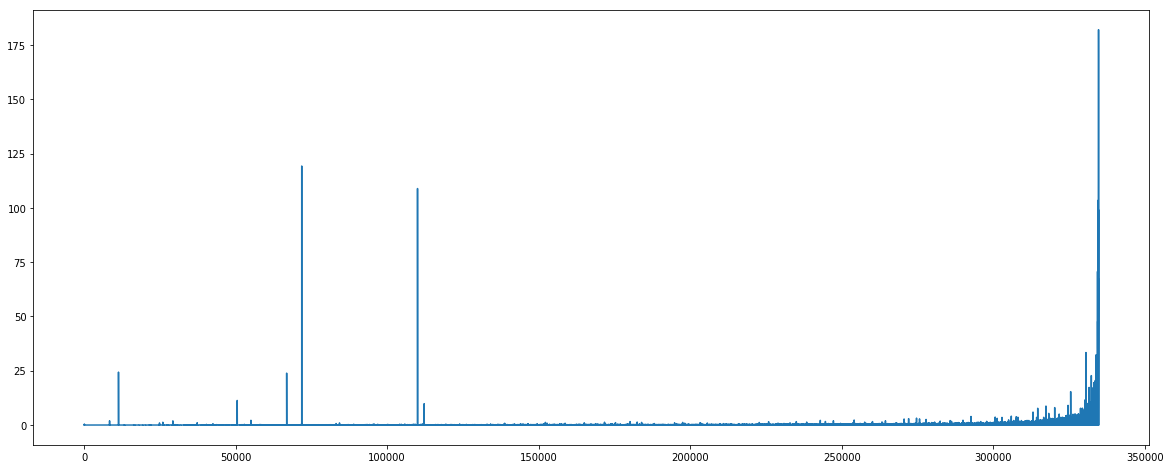

In [78]:
merchants['numerical_2'].plot.line(figsize=(20,8))

print("Data in histogram bins\n",np.histogram(merchants['numerical_2'])[0])
print("Bins\n",np.histogram(merchants['numerical_2'])[1])

print("Mean:", np.mean(merchants['numerical_2']))

In [79]:
vc_numerical_1 = merchants['numerical_1'].value_counts()
vc_numerical_2 = merchants['numerical_2'].value_counts()
print("Value counts of 'numerical_1`")
vc_numerical_1.head(20)

Value counts of 'numerical_1`


-0.057471    228788
-0.047556     41528
-0.037641     15689
-0.027726      8297
-0.017811      5249
-0.007896      3739
 0.002019      2874
 0.011934      2249
 0.021849      1869
 0.031763      1642
 0.041678      1363
 0.051593      1220
 0.061508      1079
 0.071423       927
 0.081338       866
 0.091253       770
 0.101168       719
 0.111083       619
 0.120998       562
 0.130913       507
Name: numerical_1, dtype: int64

In [80]:
outliers_numerical_1 = merchants.loc[merchants['numerical_1'] > 20, :]
outliers_numerical_2 = merchants.loc[merchants['numerical_2'] > 20, :]
outliers_numerical_1.head(10)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,category_4,city_id,state_id,category_2,merchant_address_id,sales_incrase_range,purchase_incrase_range
11364,M_ID_508ecbdcde,35,650,29,25.671706,24.313364,N,A,A,Y,158,15,1,M_ID_508ecbdcde_650_29_158_15_1,4,4
66837,M_ID_26d4fadb60,35,80,37,24.243960,23.847364,N,A,A,Y,17,22,4,M_ID_26d4fadb60_80_37_17_22_4,4,4
71810,M_ID_b794b9d9e8,35,511,7,136.827699,119.278318,N,A,A,Y,69,9,1,M_ID_b794b9d9e8_511_7_69_9_1,4,4
110011,M_ID_ae9fe1605a,35,462,31,128.628073,108.897413,N,A,A,Y,69,9,1,M_ID_ae9fe1605a_462_31_69_9_1,4,4
330524,M_ID_63ece6c9c1,35,462,31,36.597931,33.345842,N,B,B,Y,158,15,1,M_ID_63ece6c9c1_462_31_158_15_1,4,4
332300,M_ID_323617d0d5,35,511,7,23.123576,22.717065,Y,B,B,Y,0,0,0,M_ID_323617d0d5_511_7_0_0_0,4,4
333104,M_ID_b18d2bae5b,35,511,7,20.040040,19.435231,N,B,B,N,0,16,1,M_ID_b18d2bae5b_511_7_0_16_1,4,4
333616,M_ID_83ada27927,35,130,41,20.555615,20.506041,N,B,B,N,0,15,1,M_ID_83ada27927_130_41_0_15_1,3,4
333857,M_ID_235fba1cce,35,511,7,22.746809,22.032936,N,A,A,Y,17,22,4,M_ID_235fba1cce_511_7_17_22_4,4,4
333867,M_ID_5b9e251eea,35,511,7,32.136224,30.569669,N,A,A,Y,137,19,3,M_ID_5b9e251eea_511_7_137_19_3,4,4


In [81]:
vc_1 = merchants['numerical_1'].value_counts()
vc_1 = vc_1.reset_index()
vc_1 = vc_1.rename(columns={'index':'sales_rating'})
vc_1 = vc_1.sort_values(by='sales_rating', ascending=False)
vc_1 = vc_1.reset_index(drop=True)
vc_1 = vc_1.drop('numerical_1', axis=1)
vc_1 = vc_1.reset_index(drop=False)
vc_1 = vc_1.set_index('sales_rating')
vc_dict_1 = vc_1.to_dict()

vc_2 = merchants['numerical_2'].value_counts()
vc_2 = vc_2.reset_index()
vc_2 = vc_2.rename(columns={'index':'purchase_rating'})
vc_2 = vc_2.sort_values(by='purchase_rating', ascending=False)
vc_2 = vc_2.reset_index(drop=True)
vc_2 = vc_2.drop('numerical_2', axis=1)
vc_2 = vc_2.reset_index(drop=False)
vc_2 = vc_2.set_index('purchase_rating')
vc_dict_2 = vc_2.to_dict()

In [82]:
# merchants['numerical_1'] = merchants['numerical_1'].map(vc_dict_1['index'])
# merchants['numerical_2'] = merchants['numerical_2'].map(vc_dict_2['index'])
merchants['numerical_1'] = np.round(merchants['numerical_1'] / 0.009914905 + 5.79639, 0)
merchants['numerical_2'] = np.round(merchants['numerical_2'] / 0.009914905 + 5.79639, 0)

merchants.head(10)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,category_4,city_id,state_id,category_2,merchant_address_id,sales_incrase_range,purchase_incrase_range
0,M_ID_838061e48c,8353,792,9,0.0,0.0,N,E,E,N,242,9,1,M_ID_838061e48c_792_9_242_9_1,5,4
1,M_ID_9339d880ad,3184,840,20,0.0,0.0,N,E,E,N,22,16,1,M_ID_9339d880ad_840_20_22_16_1,5,4
2,M_ID_e726bbae1e,447,690,1,0.0,0.0,N,E,E,N,0,5,5,M_ID_e726bbae1e_690_1_0_5_5,5,4
3,M_ID_a70e9c5f81,5026,792,9,0.0,0.0,Y,E,E,Y,0,0,0,M_ID_a70e9c5f81_792_9_0_0_0,5,4
4,M_ID_64456c37ce,2228,222,21,0.0,0.0,Y,E,E,Y,0,0,0,M_ID_64456c37ce_222_21_0_0_0,5,1
5,M_ID_a0915f62b5,20201,87,27,0.0,0.0,N,E,E,Y,160,21,5,M_ID_a0915f62b5_87_27_160_21_5,5,4
6,M_ID_bfd41933db,33861,792,9,0.0,0.0,N,E,E,N,60,16,1,M_ID_bfd41933db_792_9_60_16_1,5,4
7,M_ID_d8ff08219e,16430,529,20,0.0,0.0,Y,E,E,Y,0,0,0,M_ID_d8ff08219e_529_20_0_0_0,5,4
8,M_ID_c5b389236d,37179,813,29,0.0,0.0,N,E,E,N,248,15,1,M_ID_c5b389236d_813_29_248_15_1,5,4
9,M_ID_d2162ed113,112122,81,29,0.0,0.0,Y,E,E,Y,0,0,0,M_ID_d2162ed113_81_29_0_0_0,5,4


In [83]:
merchants.groupby('numerical_1')['merchant_id'].count()

numerical_1
0.0        228788
1.0         41528
2.0         15689
3.0          8297
4.0          5249
5.0          3739
6.0          2874
7.0          2249
8.0          1869
9.0          1642
10.0         1363
11.0         1220
12.0         1079
13.0          927
14.0          866
15.0          770
16.0          719
17.0          619
18.0          562
19.0          507
20.0          467
21.0          444
22.0          392
23.0          385
24.0          316
25.0          316
26.0          286
27.0          293
28.0          299
29.0          259
            ...  
4979.0          1
4980.0          1
5061.0          1
5110.0          1
5270.0          1
5416.0          1
5417.0          1
5548.0          1
5738.0          1
6029.0          1
6514.0          1
6551.0          1
6802.0          1
7162.0          1
7502.0          1
7716.0          1
8091.0          1
8278.0          1
8306.0          1
10040.0         1
10534.0         1
10655.0         1
10863.0         1
11890.0         

In [84]:
merchants = merchants.drop(['category_1'], axis=1)

In [85]:
merchants['most_recent_sales_range'] = merchants['most_recent_sales_range']\
                                            .map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5})
merchants['most_recent_purchases_range'] = merchants['most_recent_purchases_range']\
                                            .map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5})


In [86]:
merchants['recent_activity_range'] = merchants['most_recent_sales_range'] + merchants['most_recent_purchases_range']
merchants['increase_in_activity_range'] = merchants['sales_incrase_range'] + merchants['purchase_incrase_range']
merchants['numerical_range'] = merchants['numerical_1'] + merchants['numerical_2']


In [87]:
vc1 = merchants['recent_activity_range'].value_counts()
vc2 = merchants['increase_in_activity_range'].value_counts()
vc1.head(10)

10    141459
8      74146
9      67647
7      24147
6      19600
5       3502
4       2870
3        701
2        624
Name: recent_activity_range, dtype: int64

In [88]:
merchants['merchant_rating'] = merchants['recent_activity_range'] + merchants['increase_in_activity_range']

In [89]:
merchants = merchants.drop(['recent_activity_range', 'increase_in_activity_range'], axis=1)

In [90]:
merchants = merchants.drop(['most_recent_sales_range', 'most_recent_purchases_range',
                            'sales_incrase_range', 'purchase_incrase_range',
                            'numerical_1', 'numerical_2'], axis=1)


In [91]:
u = merchants['merchant_address_id'].value_counts()
print("Number of merchant_id with more than one observations:", len(u[u.values > 1]))
multi_obs_merchant_ids = u[u.values > 1].index 
multi_observ_table_merchants = merchants[merchants['merchant_address_id'].isin(multi_obs_merchant_ids)]
marchant_id_groups_m = multi_observ_table_merchants.groupby('merchant_address_id')

indices_to_drop = []
total = 0
for n in list(marchant_id_groups_m.groups.keys()):
    a_merchant_id_group_m = marchant_id_groups_m.get_group(n)
    size_of_group = a_merchant_id_group_m.shape[0]
    total += size_of_group
    size_after_dropped = size_of_group
    x = [col for col in a_merchant_id_group_m.columns if a_merchant_id_group_m[col].nunique()!=1]
    drop_this = []
    
    if not set(x).isdisjoint(['merchant_rating']): # 'merchant_rating' is different
        id_to_drop = a_merchant_id_group_m[a_merchant_id_group_m['merchant_rating']!=max(a_merchant_id_group_m['merchant_rating'])].index  
        a_merchant_id_group_m = a_merchant_id_group_m.drop(list(id_to_drop), axis=0)
        drop_this = drop_this + list(id_to_drop)
        size_after_dropped = a_merchant_id_group_m.shape[0]
    
    if size_after_dropped > 1 and not set(x).isdisjoint(['numerical_range']):
        id_to_drop = a_merchant_id_group_m[a_merchant_id_group_m['numerical_range']!=max(a_merchant_id_group_m['numerical_range'])].index
        a_merchant_id_group_m = a_merchant_id_group_m.drop(list(id_to_drop), axis=0)
        drop_this = drop_this + list(id_to_drop)
        size_after_dropped = a_merchant_id_group_m.shape[0]
        
    if size_after_dropped > 1 and not set(x).isdisjoint(['merchant_group_id']):
        id_to_drop = a_merchant_id_group_m[a_merchant_id_group_m['merchant_group_id']!=min(a_merchant_id_group_m['merchant_group_id'])].index
        a_merchant_id_group_m = a_merchant_id_group_m.drop(list(id_to_drop), axis=0)
        drop_this = drop_this + list(id_to_drop)
        size_after_dropped = a_merchant_id_group_m.shape[0]
        
    #print("Key=", n, "\tSize=", size_of_group, "\tDrop=", drop_this)
    indices_to_drop = indices_to_drop + drop_this
# end of for loop
a_merchant_id_group_m = marchant_id_groups_m.get_group('M_ID_9b0ef314cf_400_7_231_9_1') 
    
merchants = merchants.drop(indices_to_drop, axis=0)
merchants = merchants.reset_index(drop=True)
    
print("%d observations for %d merchant ids. %d duplicates deleted" %(total, 
                                                                     len(list(marchant_id_groups_m.groups.keys())), 
                                                                     len(indices_to_drop)))
merchants = merchants.drop(['merchant_group_id'], axis=1)

merchants.head(10)

Number of merchant_id with more than one observations: 40
102 observations for 40 merchant ids. 62 duplicates deleted


,merchant_id,merchant_category_id,subsector_id,category_4,city_id,state_id,category_2,merchant_address_id,numerical_range,merchant_rating
0,M_ID_838061e48c,792,9,N,242,9,1,M_ID_838061e48c_792_9_242_9_1,0.0,19
1,M_ID_9339d880ad,840,20,N,22,16,1,M_ID_9339d880ad_840_20_22_16_1,0.0,19
2,M_ID_e726bbae1e,690,1,N,0,5,5,M_ID_e726bbae1e_690_1_0_5_5,0.0,19
3,M_ID_a70e9c5f81,792,9,Y,0,0,0,M_ID_a70e9c5f81_792_9_0_0_0,0.0,19
4,M_ID_64456c37ce,222,21,Y,0,0,0,M_ID_64456c37ce_222_21_0_0_0,0.0,16
5,M_ID_a0915f62b5,87,27,Y,160,21,5,M_ID_a0915f62b5_87_27_160_21_5,0.0,19
6,M_ID_bfd41933db,792,9,N,60,16,1,M_ID_bfd41933db_792_9_60_16_1,0.0,19
7,M_ID_d8ff08219e,529,20,Y,0,0,0,M_ID_d8ff08219e_529_20_0_0_0,0.0,19
8,M_ID_c5b389236d,813,29,N,248,15,1,M_ID_c5b389236d_813_29_248_15_1,0.0,19
9,M_ID_d2162ed113,81,29,Y,0,0,0,M_ID_d2162ed113_81_29_0_0_0,0.0,19


In [92]:
merchants.shape

(334634, 10)

In [93]:
merchants.head().T

,0,1,2,3,4
merchant_id,M_ID_838061e48c,M_ID_9339d880ad,M_ID_e726bbae1e,M_ID_a70e9c5f81,M_ID_64456c37ce
merchant_category_id,792,840,690,792,222
subsector_id,9,20,1,9,21
category_4,N,N,N,Y,Y
city_id,242,22,0,0,0
state_id,9,16,5,0,0
category_2,1,1,5,0,0
merchant_address_id,M_ID_838061e48c_792_9_242_9_1,M_ID_9339d880ad_840_20_22_16_1,M_ID_e726bbae1e_690_1_0_5_5,M_ID_a70e9c5f81_792_9_0_0_0,M_ID_64456c37ce_222_21_0_0_0
numerical_range,0,0,0,0,0
merchant_rating,19,19,19,19,16


In [106]:
merchants['merchant_rating'].nunique()

16

In [95]:
merchants.columns.values

array(['merchant_id', 'merchant_category_id', 'subsector_id', 'category_4', 'city_id', 'state_id',
       'category_2', 'merchant_address_id', 'numerical_range', 'merchant_rating'], dtype=object)

In [97]:
merchants.drop(['merchant_category_id', 'subsector_id', 'city_id', 'state_id', 'category_2' ], axis=1, inplace=True)

In [99]:
merchants.shape

(334634, 5)

In [102]:
merchants['category_4'] = merchants['category_4'].map({'Y':1, 'N':0}) 

In [103]:
merchants.head()

,merchant_id,category_4,merchant_address_id,numerical_range,merchant_rating
0,M_ID_838061e48c,0,M_ID_838061e48c_792_9_242_9_1,0.0,19
1,M_ID_9339d880ad,0,M_ID_9339d880ad_840_20_22_16_1,0.0,19
2,M_ID_e726bbae1e,0,M_ID_e726bbae1e_690_1_0_5_5,0.0,19
3,M_ID_a70e9c5f81,1,M_ID_a70e9c5f81_792_9_0_0_0,0.0,19
4,M_ID_64456c37ce,1,M_ID_64456c37ce_222_21_0_0_0,0.0,16


In [104]:
merchants.to_feather('merchants_df')